In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout,LayerNormalization, MultiHeadAttention, Add
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# IMPORTING DATASET
dataset = pd.read_csv('/content/drive/MyDrive/apple_share_price.csv',usecols=[1,2,3,4])
dataset = dataset.reindex(index = dataset.index[::-1])
print(dataset)

        Open    High     Low   Close
1663   46.52   47.18   46.41   47.08
1662   47.49   47.50   46.88   47.33
1661   47.08   47.76   47.07   47.71
1660   47.82   47.89   47.56   47.68
1659   47.71   48.05   47.41   48.02
...      ...     ...     ...     ...
4     157.06  158.92  156.67  158.81
3     158.60  161.83  158.27  160.08
2     159.26  161.27  159.11  161.06
1     159.90  160.00  154.63  155.32
0     156.60  158.57  156.07  157.48

[1664 rows x 4 columns]


In [ ]:
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:],dataset[train_size:len(dataset),:]

In [ ]:
# split a multivariate sequence into samples
def create_dataset(sequences, n_steps):
  X, y = list(), list()
  for i in range(len(sequences)):
  # find the end of this pattern
    end_ix = i + n_steps
  # check if we are beyond the dataset
    if end_ix > len(sequences)-1:
      break
  # gather input and output parts of the pattern
    seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape)

(1112, 2, 4)


In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):#parameter
# Normalization and Attention
  x = LayerNormalization(epsilon=1e-6)(inputs)# input ois normalized epsilon applied to avoid division by zero
  x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)#First layer of encoder (x,x) because here oit is used self attenstion
  x = Dropout(dropout)(x)
  res = Add()([x, inputs])# add function used here because there is a chance for vanishing gradient. By eliminating all the complex connection it creates an additional  short path to flow the gradient

# Feed Forward Network
  x = LayerNormalization(epsilon=1e-6)(res)
  x = Dense(ff_dim, activation="relu")(x)
  x = Dropout(dropout)(x)
  x = Dense(inputs.shape[-1])(x)
  x = Dropout(dropout)(x)
  return Add()([x, res])

In [ ]:
def transformer_decoder(inputs, encoder_outputs, head_size, num_heads, ff_dim, dropout=0):#parameters
# Self Attention
  x = LayerNormalization(epsilon=1e-6)(inputs)
  x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
  x = Dropout(dropout)(x)#tocken generated in decoder
  res = Add()([x, inputs])

# Cross Attention with Encoder Outputs
  x = LayerNormalization(epsilon=1e-6)(res)
  x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, encoder_outputs)
  x = Dropout(dropout)(x)
  res = Add()([x, res])

# Feed Forward Network
  x = LayerNormalization(epsilon=1e-6)(res)
  x = Dense(ff_dim, activation="relu")(x)# relu used to handle non-linearity
  x = Dropout(dropout)(x)
  x = Dense(inputs.shape[-1])(x)# to equalize the dimension(as input)
  x = Dropout(dropout)(x)
  return Add()([x, res])# skip connection between 2 layers

  # skip connection is used to make more efficient gradient

In [ ]:
def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_encoder_blocks,num_decoder_blocks, dropout=0):#parameters
  inputs = Input(shape=input_shape)
# Encoder
  x = inputs
  for _ in range(num_encoder_blocks):
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
# Decoder
  decoder_inputs = Input(shape=(1, input_shape[1]))
  y = decoder_inputs
  for _ in range(num_decoder_blocks):
    y = transformer_decoder(y, x, head_size, num_heads, ff_dim, dropout)
# Reshape output to 2D tensor
  y = tf.squeeze(y, axis=1)#squeeze for reducing the dimensionality to 1-D
  outputs = Dense(input_shape[1])(y)
  model = Model([inputs, decoder_inputs], outputs)#defines the model
  return model

In [ ]:
# Model parameters
sequence_length = 2
input_shape = (sequence_length, 4) # 2 days, 4 features
head_size = 256
num_heads = 4
ff_dim = 256
num_encoder_blocks = 2
num_decoder_blocks = 2
dropout = 0.1

In [ ]:
model = build_transformer_model(input_shape, head_size,num_heads, ff_dim, num_encoder_blocks, num_decoder_blocks,dropout)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 2, 4)]               0         []                            
                                                                                                  
 layer_normalization_10 (La  (None, 2, 4)                 8         ['input_3[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_6 (Mu  (None, 2, 4)                 19460     ['layer_normalization_10[0][0]
 ltiHeadAttention)                                                  ',                            
                                                                     'layer_normalization_10

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
#Train the model
decoder_input_data = np.zeros((trainX.shape[0], 1,trainX.shape[2])) # Shape (num_samples, 1, num_features)
model.fit([trainX, decoder_input_data], trainY, epochs=30,batch_size=16, validation_split=0.2)

Epoch 1/30
56/56 [==============================] - 17s 71ms/step - loss: 0.0395 - val_loss: 0.0353
Epoch 2/30
56/56 [==============================] - 2s 29ms/step - loss: 0.0154 - val_loss: 0.0691
Epoch 3/30
56/56 [==============================] - 2s 38ms/step - loss: 0.0117 - val_loss: 0.0412
Epoch 4/30
56/56 [==============================] - 5s 98ms/step - loss: 0.0091 - val_loss: 0.0252
Epoch 5/30
56/56 [==============================] - 7s 117ms/step - loss: 0.0070 - val_loss: 0.0260
Epoch 6/30
56/56 [==============================] - 3s 59ms/step - loss: 0.0068 - val_loss: 0.0219
Epoch 7/30
56/56 [==============================] - 3s 49ms/step - loss: 0.0067 - val_loss: 0.0132
Epoch 8/30
56/56 [==============================] - 2s 31ms/step - loss: 0.0062 - val_loss: 0.0093
Epoch 9/30
56/56 [==============================] - 2s 30ms/step - loss: 0.0041 - val_loss: 0.0105
Epoch 10/30
56/56 [==============================] - 2s 27ms/step - loss: 0.0051 - val_loss: 0.0226
Epoch 1

In [ ]:
decoder_input_data_test = np.zeros((testX.shape[0], 1,testX.shape[2])) # Shape (num_samples, 1, num_features)
test_predict = model.predict([testX,decoder_input_data_test])
test_predict = scaler.inverse_transform(test_predict) #Inverse transform to original scale
actual_testY = scaler.inverse_transform(testY)

18/18 [==============================] - 3s 19ms/step


In [ ]:
import math
from sklearn.metrics import mean_squared_error
testScore =math.sqrt(mean_squared_error(actual_testY,test_predict))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 14.84 RMSE


In [ ]:
decoder_input_data_train = np.zeros((trainX.shape[0], 1,trainX.shape[2])) # Shape (num_samples, 1, num_features)
train_predict = model.predict([trainX,decoder_input_data_train])
train_predict = scaler.inverse_transform(train_predict) #Inverse transform to original scale
actual_trainY = scaler.inverse_transform(trainY)

35/35 [==============================] - 1s 18ms/step


In [ ]:
trainScore =math.sqrt(mean_squared_error(actual_trainY,train_predict))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 7.23 RMSE


In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] =train_predict

In [ ]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2):len(dataset), :] = test_predict

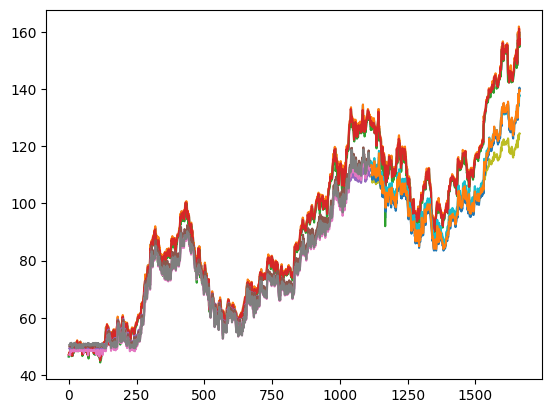

In [ ]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()